# Crime Analysis
## Team 6
### Jeffrey Bohn, Nirmalya Chanda, Melissa Freeman, Anna Isaacson, Jong Geun Shin

# Introduction
In this notebook, we explore several components of crime, touching upon questions of both personal and business safety. Our analysis is divided into questions relevant to individuals, questions relevant to the police force, and questions relevant to business. Of course, all crime-related questions may be relevant to all groups.

Our personal safety questions are:
- What factors contribute to the number of crimes that occur on a given day?
- Do some areas have more crime than others?
- Given that there has been a crime, what factors contribute to whether or not a shooting occurs with the crime?

Our enforcement question is:
- Can crimes be classified by neighborhood, time of day, or time of year?

Our business question is:
- In each of Boston's neighborhoods, which streets are most likely to see crimes of paricular concern to businesses, such as burglary and vandalism?

For each question, we follow a consistent pattern. We begin with data wrangling and exploratory data analysis (EDA). In most cases, we proceed to apply a statistical model. Finally, in some cases, we evaluate the model with residual charts or confusion matrices.

# Part I: Load and clean the data

In [147]:
# Load modules, apply settings
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import requests
import json
from statsmodels.formula.api import ols
from statsmodels.formula.api import logit
import datetime
import calendar
from sklearn.cross_validation import train_test_split
from sklearn.cluster import KMeans
%matplotlib inline
mpl.style.use('fivethirtyeight')
pd.options.mode.chained_assignment = None

In [148]:
# Load the primary crime data
base_url = 'https://raw.githubusercontent.com/aisaacso/SafeBoss/master/'
crime_url = base_url + 'Crime_Incident_Reports.csv'
crime = pd.read_csv(crime_url, low_memory = False)

In [149]:
# Create column that is guaranteed to have no NANs, for pivot table counts throughout the notebook
crime['indexer'] = 1

In [150]:
# Date clean-up

# Converts FROMDATE from str to datetime
crime['FROMDATE'] = pd.to_datetime(crime.FROMDATE, format = '%m/%d/%Y %I:%M:%S %p')

# Original range is Jul-2012 to Aug-2015; because in some cases we analyze crime counts, exclude first month of data
crime = crime[crime.FROMDATE > '2012-08-10 00:00:00']

#Add a date column
crime['Date'] = crime.FROMDATE.dt.date

In [151]:
# Convert police district codes to neighborhoods

crime = crime[crime.REPTDISTRICT.notnull()]

crime = crime[crime.REPTDISTRICT <> 'HTU']
def get_neighborhood(d):
    if d=='A1': return 'Downtown'
    elif d=='A15': return 'Charlestown'
    elif d=='A7': return 'EastBoston'
    elif d=='B2': return 'Roxbury'
    elif d=='B3': return 'Mattapan'
    elif d=='C6': return 'SouthBoston'
    elif d=='C11': return 'Dorchester'
    elif d=='D4': return 'SouthEnd'
    elif d=='D14': return 'Brighton'
    elif d=='E5': return 'WestRoxbury'
    elif d=='E13': return 'JamaicaPlain'
    elif d=='E18': return 'HydePark'
    else: return '???'

crime['Neighborhood'] = crime['REPTDISTRICT'].map(get_neighborhood)

In [152]:
# Load in weather data
weather_url = base_url + 'weather.csv' # From http://www.ncdc.noaa.gov/cdo-web/datasets
weather = pd.read_csv(weather_url)

In [153]:
# Prepare weather data for adding to crime data

# Include only Boston Logan weather station (has most consistent data)
weather = weather[weather.STATION == 'GHCND:USW00014739']

#Match date format to crime dataset's date format
weather['Date'] = pd.to_datetime(weather.DATE, format = '%Y%m%d')
weather['Date'] = weather.Date.dt.date

# Add temp categories
median = int(weather.TMAX.median())
lower = weather.TMAX.quantile(q = 0.25).astype(int)
upper = weather.TMAX.quantile(q = 0.75).astype(int)

def tmax_groups(t):
    if t<=lower: return 'Cold'
    elif (t>lower and t<=median): return 'SortaCold'
    elif (t>median and t<=upper): return 'SortaHot'
    else: return 'Hot'

def prcp_groups(p):
    if p > 0: return 1
    else: return 0
    
weather['TempGroups'] = weather['TMAX'].map(tmax_groups)
weather['Precip_Bool'] = weather['PRCP'].map(prcp_groups)

# Part II : Personal Safety
In this section, we analyze three questions: 
- What factors contribute to the number of crimes that occur on a given day?
- Do some areas have more crime than others?
- Given that there has been a crime, what factors contribute to whether or not a shooting occurs with the crime?

We expect that these questions will be especially relevant to Boston residents who wish to be aware of their personal risks of facing crime in the city.

## Part II Question 1: What factors contribute to crime per day?

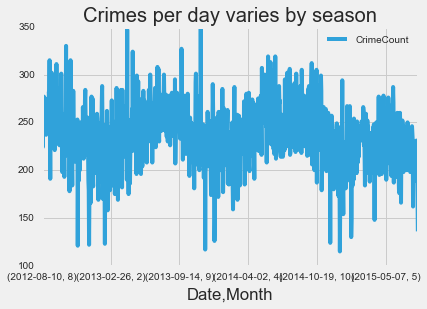

In [154]:
# EDA for seasonal variation
dates = pd.pivot_table(crime, values = ['indexer'], index = ['Date', 'Month'], aggfunc = 'count')
dates.rename(columns={'indexer': 'CrimeCount'}, inplace=True) #Rename for more logical referencing
min_crimes = dates.CrimeCount.min()
dates = dates[dates.CrimeCount != min_crimes] # Removes an outlier in Aug, 2105
dates.plot(xticks = None, title = 'Crimes per day varies by season')

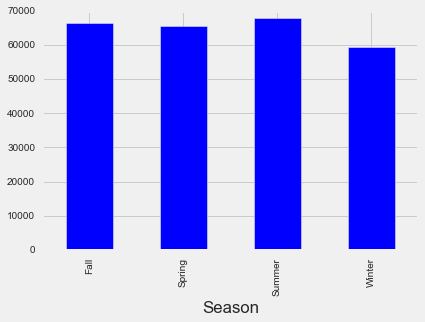

In [155]:
# EDA for season

def season_groups(m):
    if m in [12, 1, 2]: return 'Winter'
    elif m in [3, 4, 5]: return 'Spring'
    elif m in [6, 7, 8]: return 'Summer'
    else: return 'Fall'
    
dates = pd.DataFrame(dates)
dates['Month'] = dates.index.get_level_values(1)
dates['Season'] = dates['Month'].map(season_groups)
seasonal = pd.pivot_table(dates, index = 'Season', values = 'CrimeCount', aggfunc = 'sum')
seasonal.plot(kind = 'bar')

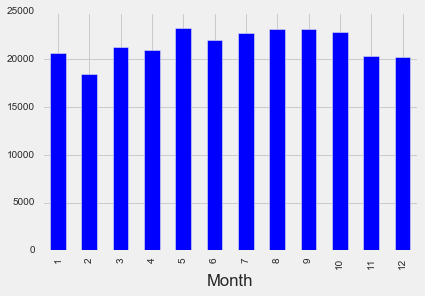

In [156]:
# EDA for month
months = pd.pivot_table(dates, index = 'Month', values = 'CrimeCount', aggfunc = 'sum')
months.plot(kind = 'bar')

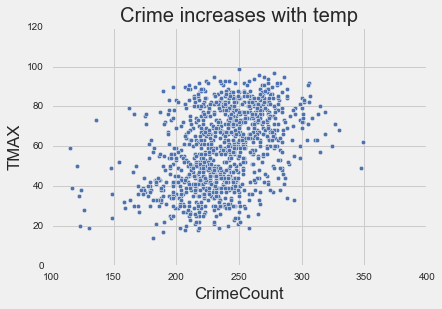

In [157]:
# EDA for temp

dates['Date'] = dates.index.get_level_values(0)
add_weather = pd.merge(dates, weather, how = 'inner', on = 'Date') # inner join excludes 10 dates
add_weather.plot(kind = 'scatter', x = 'CrimeCount', y = 'TMAX', title = 'Crime increases with temp')

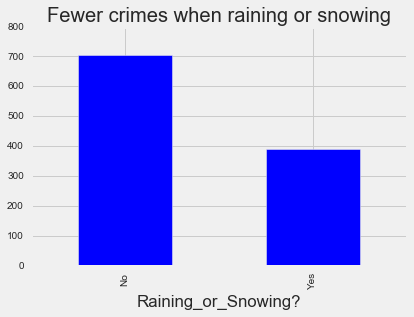

In [158]:
# EDA for precipitation
add_weather['Raining_or_Snowing?'] = add_weather['Precip_Bool'].map({0:'No', 1:'Yes'})
crime_precip = pd.pivot_table(add_weather, index = 'Raining_or_Snowing?', values = 'CrimeCount', aggfunc = 'count')
crime_precip.plot(kind = 'bar', title = 'Fewer crimes when raining or snowing')

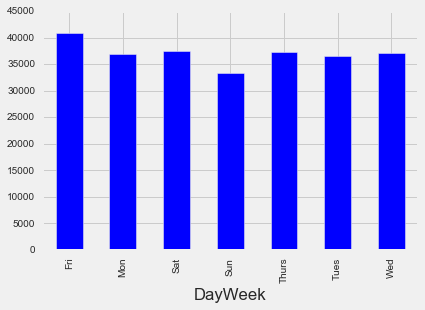

In [159]:
#EDA for day of the week

def get_week_day(d):
    daynum = d.weekday()
    days = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
    return days[daynum]
add_weather['DayWeek'] = add_weather['Date'].map(get_week_day)
weekdays = pd.pivot_table(add_weather, index = 'DayWeek', values = 'CrimeCount', aggfunc = 'sum')
weekdays.plot(kind = 'bar')

In [160]:
# Build model
# Removed variables: Spring
season_dummies = pd.get_dummies(add_weather['Season']).iloc[:, 1:]
day_dummies = pd.get_dummies(add_weather['DayWeek']).iloc[:, 1:]
temp_dummies = pd.get_dummies(add_weather['TempGroups']).iloc[:, 1:]
dates_dummy_df = add_weather.join([day_dummies, season_dummies, temp_dummies])
train, test = train_test_split(dates_dummy_df, test_size = 0.2)
perday_model = ols(data=train, formula='CrimeCount ~  Summer + Winter + Hot + SortaCold + SortaHot +\
Mon + Sat + Sun + Thurs + Tues + Wed + Precip_Bool')
perday_result = perday_model.fit()
perday_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             CrimeCount   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     37.85
Date:                Tue, 26 Apr 2016   Prob (F-statistic):           3.76e-71
Time:                        11:45:55   Log-Likelihood:                -4071.4
No. Observations:                 876   AIC:                             8169.
Df Residuals:                     863   BIC:                             8231.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept     246.9641      3.251     75.965      0.000       240.583   253.345
Summer         -4.5556      2.782     -1.638      0.102       -10.016     0.904
Winter         -5.3189      2.618     -2.032      0.042       -10.456    -0.181
Hot            32.6886      3.710      8.810      0.000        25.406    39.971
SortaCold      13.3757      2.635      5.075      0.000         8.203    18.548
SortaHot       26.7742      3.066      8.734      0.000        20.757    32.791
Mon           -23.6781      3.237     -7.316      0.000       -30.031   -17.326
Sat           -24.0508      3.226     -7.454      0.000       -30.383   -17.718
Sun           -48.0006      3.237    -14.828      0.000       -54.354   -41.647
Thurs         -22.9169      3.207     -7.146      0.000       -29.211   -16.623
Tues          -25.8350      3.202     -8.068      0.000       -32.120   -19.550
Wed           -23.6548      3.226     -7.332      0.000       -29.987   -17.322
Precip_Bool    -3.7924      1.809     -2.096      0.036        -7.343    -0.242
==============================================================================
Omnibus:                       71.510   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.665
Skew:                          -0.427   Prob(JB):                     1.08e-41
Kurtosis:                       5.107   Cond. No.                         9.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

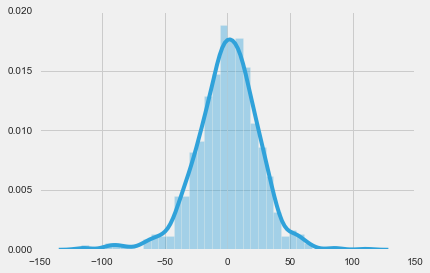

In [161]:
# Analyze the model

residuals = perday_result.resid
fig = sns.distplot(residuals)

In [162]:
# Create prediction for test data
test['Prediction'] = perday_result.predict(test)

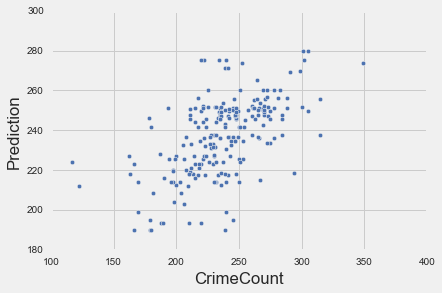

In [163]:
# Plot the prediction against the actual
test.plot(kind = 'scatter', x='CrimeCount', y = 'Prediction')

In [164]:
# Linear regression on correlation between prediction and actual
model_test = ols(data=test, formula = 'Prediction ~ CrimeCount')
test_result = model_test.fit()

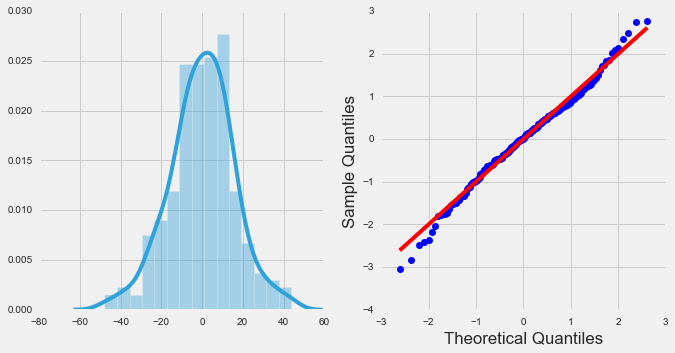

In [165]:
# Checking residuals of test regression
test_resid = test_result.resid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(test_resid, ax=axes[0]);
sm.qqplot(test_resid, fit=True, line='s', ax=axes[1]);

# Part II Question 2: Do some areas have more crimes than others?

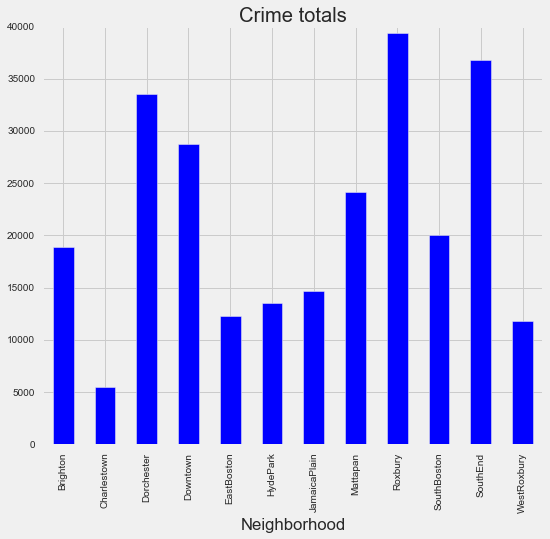

In [166]:
#EDA for crime overall
reptd = pd.pivot_table(crime, values = 'indexer', index = 'Neighborhood', aggfunc = 'count')
reptd.plot(kind = 'bar', sort_columns = True, title = 'Crime totals', figsize = (8,7))

In [167]:
# load in pop file
pop_url = base_url + 'pop.csv' # From our own web research
pop_df = pd.read_csv(pop_url)

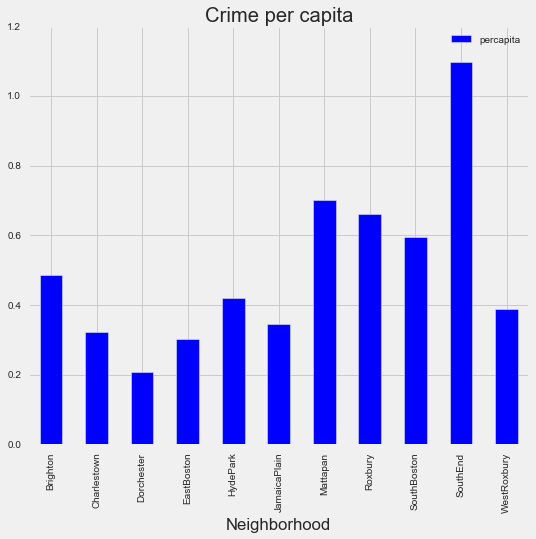

In [168]:
# EDA for crime per capita

reptd = pd.DataFrame(reptd)
reptd.rename(columns={'indexer': 'CrimeCount'}, inplace=True) #Rename for more logical referencing
reptd['Neighborhood'] = reptd.index.get_level_values(0)
add_pop = pd.merge(reptd, pop_df, how = 'inner', on = 'Neighborhood')
add_pop['percapita'] = add_pop.CrimeCount / add_pop.Population
add_pop.plot(kind = 'bar', x='Neighborhood', y = 'percapita', sort_columns = True, title = 'Crime per capita', figsize = (8,7))

# Part II Question 3: Given a crime, what factors contribute to crime including a shooting?

In [169]:
# Dummy for shooting
crime['Shoot_Status']=crime['Shooting'].map({'No':0,'Yes':1}).astype(int)

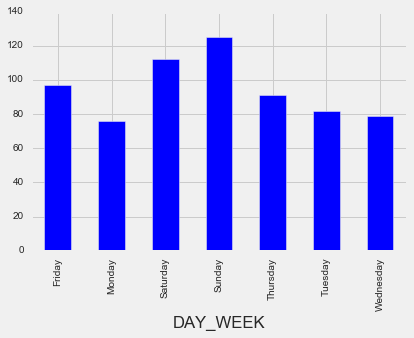

In [170]:
# EDA for day of the week
shoot = crime[crime.Shoot_Status==1]
days = pd.pivot_table(shoot, values = 'indexer', index = 'DAY_WEEK', aggfunc = 'count')
days.plot(kind = 'bar')

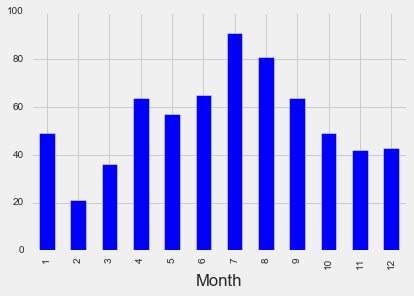

In [171]:
# EDA for month
months = pd.pivot_table(shoot, values = 'indexer', index = 'Month', aggfunc = 'count')
months.plot(kind = 'bar')

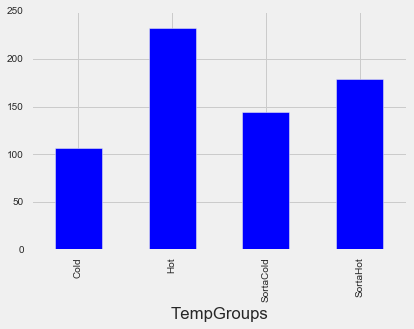

In [172]:
# EDA for weather
weather_shoot = pd.merge(shoot, weather, how = 'inner', on = 'Date')
temps = pd.pivot_table(weather_shoot, index = 'TempGroups', values = 'indexer', aggfunc = 'count')
temps.plot(kind = 'bar')

In [173]:
# Add in weather data to crime dataset
crime_weather = pd.merge(crime, weather, how = 'outer', on = 'Date')

In [174]:
#Add a column for the month name (regression can't handle numbers as col names)
def mo_as_name(mo):
    return calendar.month_name[mo]

crime_weather['MoName'] =  crime_weather['Month'].map(mo_as_name)

In [175]:
# Data prep
week_dummies = pd.get_dummies(crime_weather['DAY_WEEK']).iloc[:, 1:]
month_dummies = pd.get_dummies(crime_weather['MoName']).iloc[:, 1:]
neigh_dummies = pd.get_dummies(crime_weather['Neighborhood']).iloc[:,1:]
temp_dummies = pd.get_dummies(crime_weather['TempGroups']).iloc[:,1:]
crtype_dummies = pd.get_dummies(crime_weather['MAIN_CRIMECODE']).iloc[:,1:]
shoot_df = crime_weather.join([week_dummies, month_dummies, neigh_dummies, temp_dummies, crtype_dummies])

In [176]:
#Regression
# Removed variables: + July + December + August + Downtown + Precip_Bool + Thursday + November + WestRoxbury + SortaCold
# + October + March + June + May + Wednesday + Tuesday   

train, test = train_test_split(shoot_df, test_size = 0.2)
model_logistic = logit(data=train, formula='Shoot_Status ~ Monday + Sunday + February + Hot + SortaHot \
+ SouthEnd + Roxbury + HydePark + JamaicaPlain + SouthBoston + Dorchester + Mattapan + EastBoston + Charlestown'
                     )
result_logistic = model_logistic.fit()

# Function for analyzing p_values; used for removing p values one by one
def analyze_p(res):
    p = res.pvalues
    p.sort_values(ascending = False, inplace = True)
    print res.prsquared
    print p
    
#analyze_p(result_logistic)
result_logistic.summary()

Optimization terminated successfully.
         Current function value: 0.016655
         Iterations 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           Shoot_Status   No. Observations:               207424
Model:                          Logit   Df Residuals:                   207409
Method:                           MLE   Df Model:                           14
Date:                Tue, 26 Apr 2016   Pseudo R-squ.:                 0.06003
Time:                        11:46:08   Log-Likelihood:                -3454.7
converged:                       True   LL-Null:                       -3675.3
                                        LLR p-value:                 2.491e-85
================================================================================
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -7.9860      0.233    -34.304      0.000        -8.442    -7.530
Monday          -0.1793      0.138     -1.302      0.193        -0.449     0.091
Sunday           0.4693      0.113      4.157      0.000         0.248     0.691
February        -0.5831      0.247     -2.362      0.018        -1.067    -0.099
Hot              0.5108      0.103      4.949      0.000         0.309     0.713
SortaHot         0.1308      0.114      1.149      0.251        -0.092     0.354
SouthEnd         0.8792      0.289      3.044      0.002         0.313     1.445
Roxbury          2.6202      0.236     11.110      0.000         2.158     3.082
HydePark         1.2120      0.342      3.546      0.000         0.542     1.882
JamaicaPlain     1.9731      0.281      7.034      0.000         1.423     2.523
SouthBoston      0.2958      0.402      0.737      0.461        -0.491     1.083
Dorchester       2.2656      0.244      9.301      0.000         1.788     2.743
Mattapan         2.6019      0.244     10.681      0.000         2.124     3.079
EastBoston       1.4720      0.325      4.528      0.000         0.835     2.109
Charlestown      0.7886      0.548      1.439      0.150        -0.285     1.863
================================================================================
"""

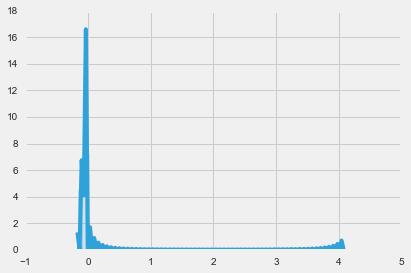

In [177]:
residuals = result_logistic.resid_dev
fig = sns.distplot(residuals)

## Part II Conclusion
Of these three questions, the results of Question 1 are most promising. The adjusted r-squared is high enough to make the model worthwhile, several of the variables show sufficiently low p-values, and the resideuals are evenly distributed. The other models need further refinement in order to provide meaningful insights.

Our analysis of Question 1 reveals that, holding all else constant, summer, winter, temperature level, precipitation, and day of the week all have a statistically significant correlation with the number of crimes on a given day. Notably, when all these other factors are held constant, there are between 43 and 54 fewer crimes on Sundays. Hot days have between 27 and 40 more crimes, again holding all else constant. These figures all use a 95% confidence interval.

# Part III: Enforcement
In this section, we analyze whether crimes be classified by neighborhood, time of day, or time of year. We imagine that these questions could be particularly relevant to Boston's police department, as they prepare for the city's varying enforcement needs. In this section, we examine only the ten most common crime types.

## Part III Question 1: Do certain kinds of common crimes happen in certain neighborhoods?

In [178]:
# Data wrangling

# Find the most common crime types
cr_counts = pd.DataFrame(pd.pivot_table(crime, index = 'MAIN_CRIMECODE', values = 'DAY_WEEK', aggfunc = 'count'))
cr_counts.sort_values('DAY_WEEK', ascending = False, inplace = True)
cr_counts = cr_counts.head(10)
top_crimes = cr_counts.index.tolist()

# Prep the data
districts = neigh_dummies.columns.tolist()
dist_cols = ['Neighborhood'] + top_crimes
neigh_classes = shoot_df[dist_cols].dropna()

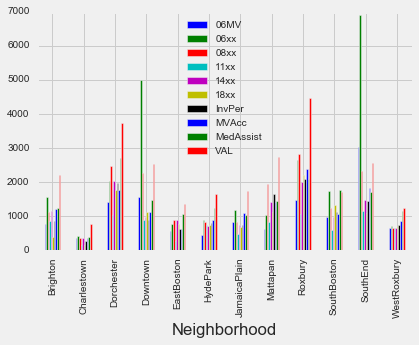

In [191]:
# EDA
districts_crimes = pd.pivot_table(neigh_classes, index = 'Neighborhood', values = top_crimes, aggfunc = 'sum')
districts_crimes.plot(kind = 'bar')

In [180]:
# Build the model
model_distcr = KMeans( n_clusters =  len(districts))
model_distcr = model_distcr.fit(neigh_classes.iloc[:,1:])
neigh_classes['kmeans_class'] = model_distcr.labels_

kmeans_class,0,1,2,3,4,5,6,7,8,9,10
Neighborhood,,,,,,,,,,,
Brighton,7476,2220,1243,1557,1118,873,1167,1221,763,862,403
Charlestown,1772,788,398,415,365,291,359,369,380,150,173
Dorchester,12572,3736,2711,2029,2480,1983,2048,1763,1416,1050,1770
Downtown,10884,2545,1483,4987,2278,897,981,1119,1570,906,1126
EastBoston,4395,1370,1071,791,897,620,900,638,571,290,771
HydePark,4572,1644,1248,888,823,810,719,882,442,748,746
JamaicaPlain,5305,1755,1030,1175,843,736,738,1095,840,471,683
Mattapan,9853,2734,1442,1041,1940,1655,1412,1425,626,841,1133
Roxbury,16017,4469,2098,2647,2816,2107,2020,2385,1483,1074,2210


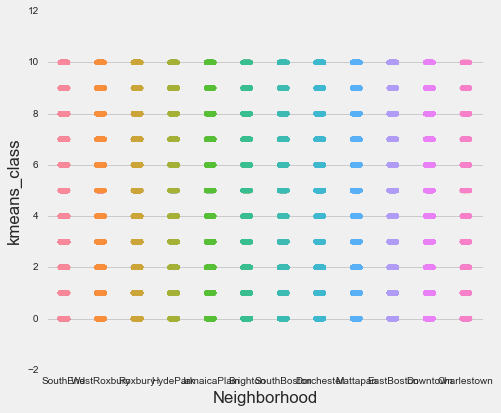

In [181]:
# Analyze the model

#Plot the classification
plt.figure(figsize=(7,6))
sns.stripplot(x='Neighborhood', y='kmeans_class', data=neigh_classes, jitter= True)

#Confusion matrix
pd.pivot_table(neigh_classes, index='Neighborhood', columns = 'kmeans_class', values = '11xx', aggfunc = 'count')

## Part III Question 2: Do certain kinds of common crimes happen at certain times of day?

In [182]:
# Data wrangling

# Adds Hour column for each crime
crime['Hour'] = crime.FROMDATE.dt.hour

# Removes the preponderance of rows for which time is 00:00:00 00:00)
crime_no_time = crime[(crime.FROMDATE.dt.hour == 0) & (crime.FROMDATE.dt.minute == 0)]
crime_no_time['no_time'] = 'indicator'
crime_time = crime.merge(crime_no_time, how='left')
crime_time = crime_time[crime_time.no_time <> 'indicator']

def time_groups(t):
    if t in [0,1,2,3,4,23]: return "Night"
    elif t in [5,6,7,8,9,10]: return "Morning"
    elif t in [11,12,13,14,15,16]: return "Midday"
    else: return "Evening"

periods = crime_time.join(crtype_dummies)
periods['timegroup'] = periods['Hour'].map(time_groups)
time_cols = ['timegroup', 'Hour'] + top_crimes
periods_classes = periods[time_cols].dropna()

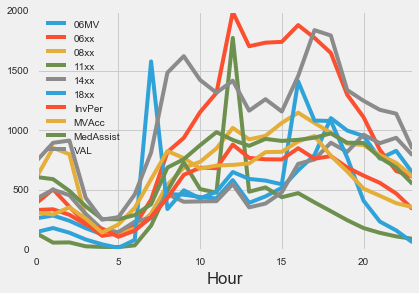

In [183]:
# EDA
hours_crimes = pd.pivot_table(periods_classes, index = 'Hour', values = top_crimes, aggfunc = 'sum')
hours_crimes.plot(kind = 'line')

In [184]:
# Build the model
model_periocr = KMeans( n_clusters =  4)
model_periocr = model_periocr.fit(periods_classes.iloc[:,2:])
periods_classes['kmeans_class'] = model_periocr.labels_

kmeans_class,0,1,2,3
timegroup,,,,
Evening,7323,8525,55258,5325
Midday,10359,7764,58432,5954
Morning,3667,6073,38215,2576
Night,2210,4085,28040,3307


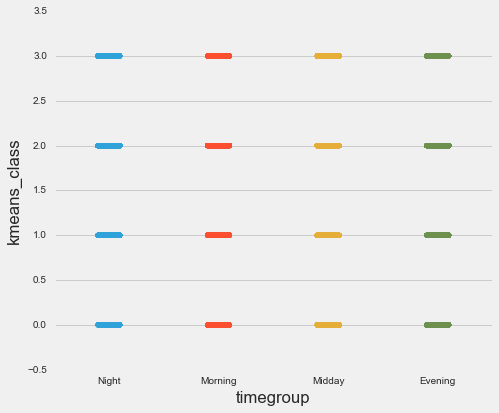

In [185]:
# Analyze the model

#Plot the classification
plt.figure(figsize=(7,6))
sns.stripplot(x='timegroup', y='kmeans_class', data=periods_classes, jitter= True)

#Confusion matrix
pd.pivot_table(periods_classes, index='timegroup', columns = 'kmeans_class', values = '11xx', aggfunc = 'count')

## Part III Question 3: Do certain types of crimes happen at certain times of year?

In [186]:
# Data wrangling
shoot_df['Season'] = shoot_df['Month'].map(season_groups)
seas_cols = ['Season'] + top_crimes
seasons_classes = shoot_df[seas_cols].dropna()

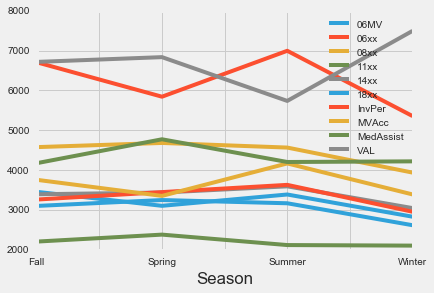

In [187]:
# EDA
seasons_crimes = pd.pivot_table(seasons_classes, index = 'Season', values = top_crimes, aggfunc = 'sum')
seasons_crimes.plot(kind = 'line')

In [188]:
# Build the model

model_seascr = KMeans( n_clusters =  4)
model_seascr = model_seascr.fit(seasons_classes.iloc[:,2:])
seasons_classes['kmeans_class'] = model_seascr.labels_

kmeans_class,0,1,2,3
Season,,,,
Fall,50915,6707,4174,4577
Spring,50214,5843,4774,4682
Summer,52238,6995,4204,4566
Winter,45877,5357,4220,3938


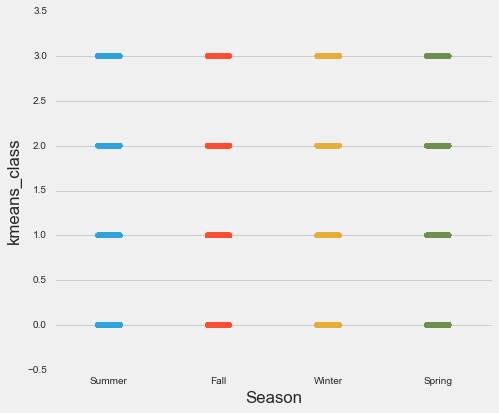

In [189]:
# Analyze the model

#Plot the classification
plt.figure(figsize=(7,6))
sns.stripplot(x='Season', y='kmeans_class', data=seasons_classes, jitter= True)

#Confusion matrix
pd.pivot_table(seasons_classes, index='Season', columns = 'kmeans_class', values = '11xx', aggfunc = 'count')

## Part III Conclusion
In this section, we attempted to classify crimes by a variety of metrics. None of these variables were effective classifiers for crime. However, as shown here, this model could be used across a number of variables to find crime categories. Again, we believe that, with further refinement, this model could be useful to law enforcement.

# Part IV: Crimes of Concern to Business-Owners
In this section, we list crimes that may be of particular concern to business owners, and we show which streets have the highest occurances of these crimes in each of Boston's neighborhoods. We imagine that entrepreneurs could examine this data when siting new businesses.

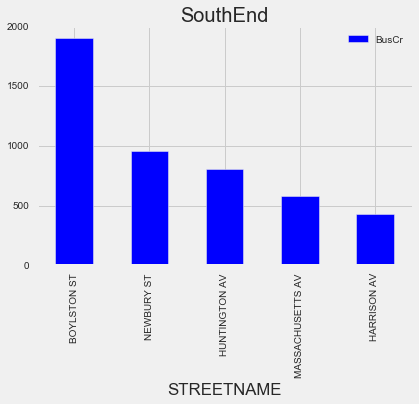

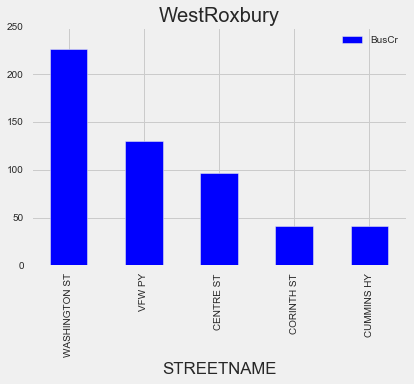

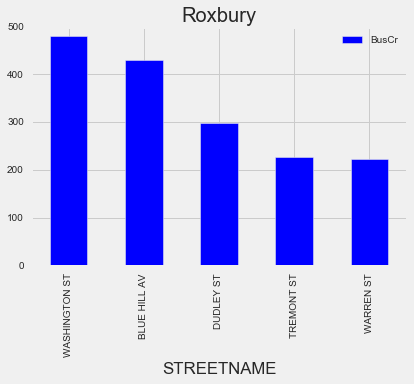

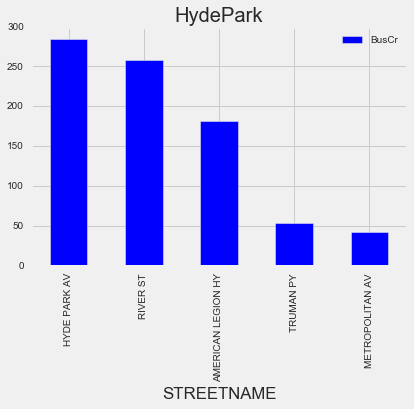

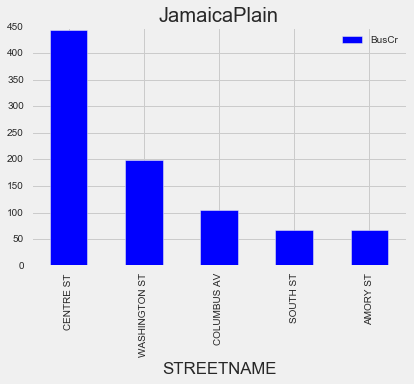

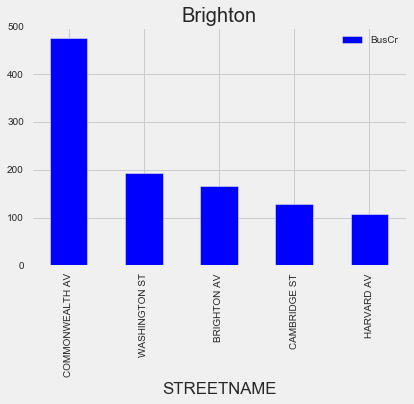

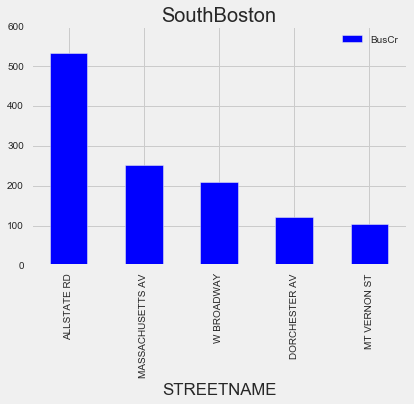

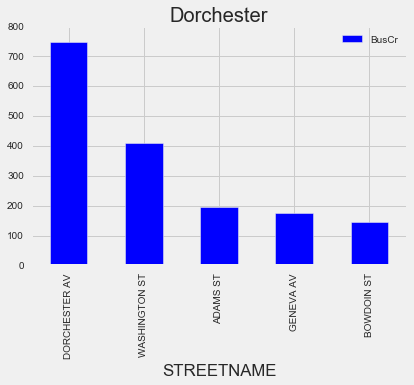

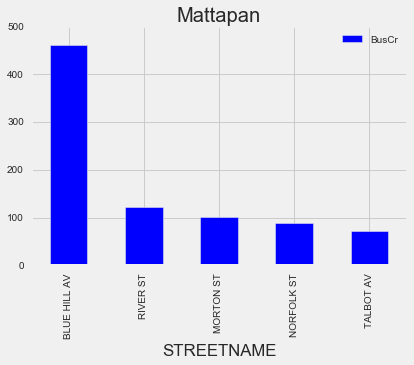

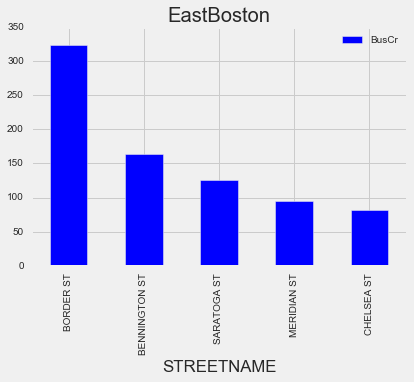

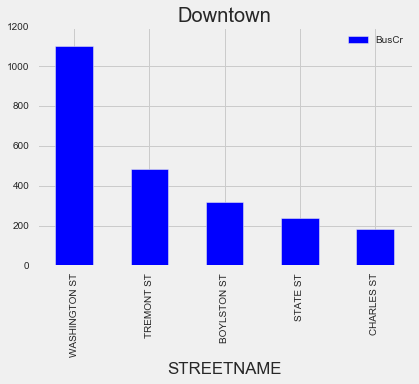

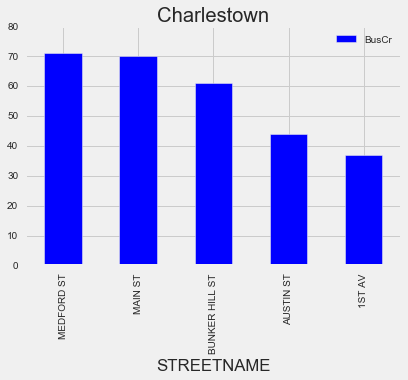

In [190]:
# create a list of business crimes
business_crimes = ['COMMERCIAL BURGLARY', 'VANDALISM', 'ROBBERY', 'OTHER LARCENY', 'BurgTools', 'ARSON', 'Larceny'\
                  'Other Burglary', 'PROSTITUTION CHARGES', 'PubDrink']

# Classify crimes based on whether or not they are business-relevant crimes
def is_bus_cr(c):
    if c in business_crimes:
        return 1
    else:
        return 0

crime['BusCr'] =  crime['INCIDENT_TYPE_DESCRIPTION'].map(is_bus_cr)
dists = crime['Neighborhood'].unique().tolist()

# Create a chart of the top five streets in each district in Boston
for d in dists:
    var = crime.loc[crime.Neighborhood == d]
    streets = pd.DataFrame(pd.pivot_table(var, values = 'BusCr', index = 'STREETNAME', aggfunc = 'sum'))
    streets.sort_values('BusCr', ascending = False, inplace = True)
    top_five = streets.head(5)
    top_five.plot(kind = 'bar', title = d)
    print

# Conclusion
In this notebook, we analyzed Boston's crime data from a variety of perspectives. We examined questions relevant to individuals, police officers, and business owners. These models and this approach could be extended to explore questions relevant to other groups of stakeholders, including youth, the elderly, minorities, and city administration and leadership. Each group has its own interests and questions with respect to crime. Other data, such as economic data, unemployment data, and demographic could also be incorporated into our models to provide further crime-related insights.